In [2]:
!pip install lambeq


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.1/152.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.9/144.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.3/364.3 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 103.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.7 MB/s eta 0:00:00


In [3]:
# First -- sentence tokenizer

from lambeq import SpacyTokeniser

tokeniser = SpacyTokeniser()
sample_sentence = "hello my name is jeff."
tokens = tokeniser.tokenise_sentence(sample_sentence)
print(tokens)

['hello', 'my', 'name', 'is', 'jeff', '.']


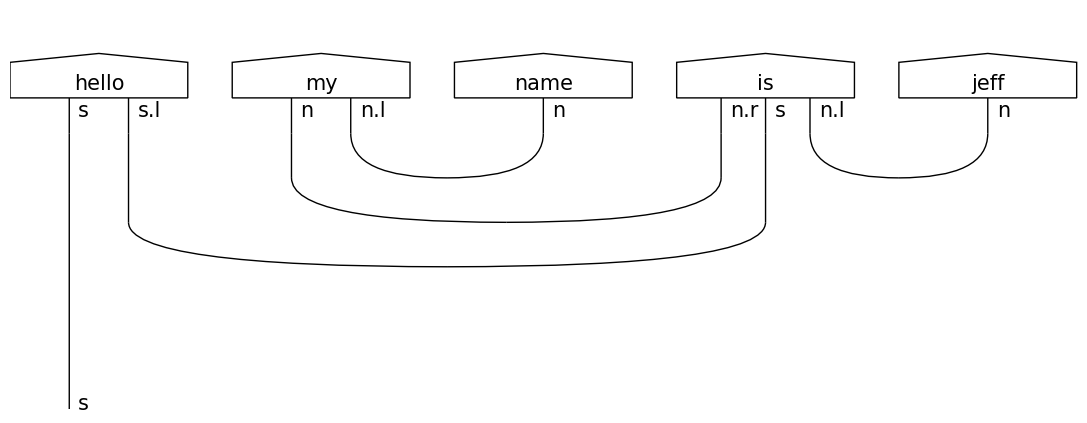

In [4]:
from lambeq import BobcatParser, pregroups
parser = BobcatParser(verbose = 'suppress')

diagram = parser.sentence2diagram(tokens, tokenised = True)
pregroups.draw(diagram, figsize = (20, 4), fontsize = 15)

In [5]:
text = "I love pizza. It is my favorite food. I could eat it every day!"
sentences = tokeniser.split_sentences(text)
sentences

['I love pizza.', 'It is my favorite food.', 'I could eat it every day!']

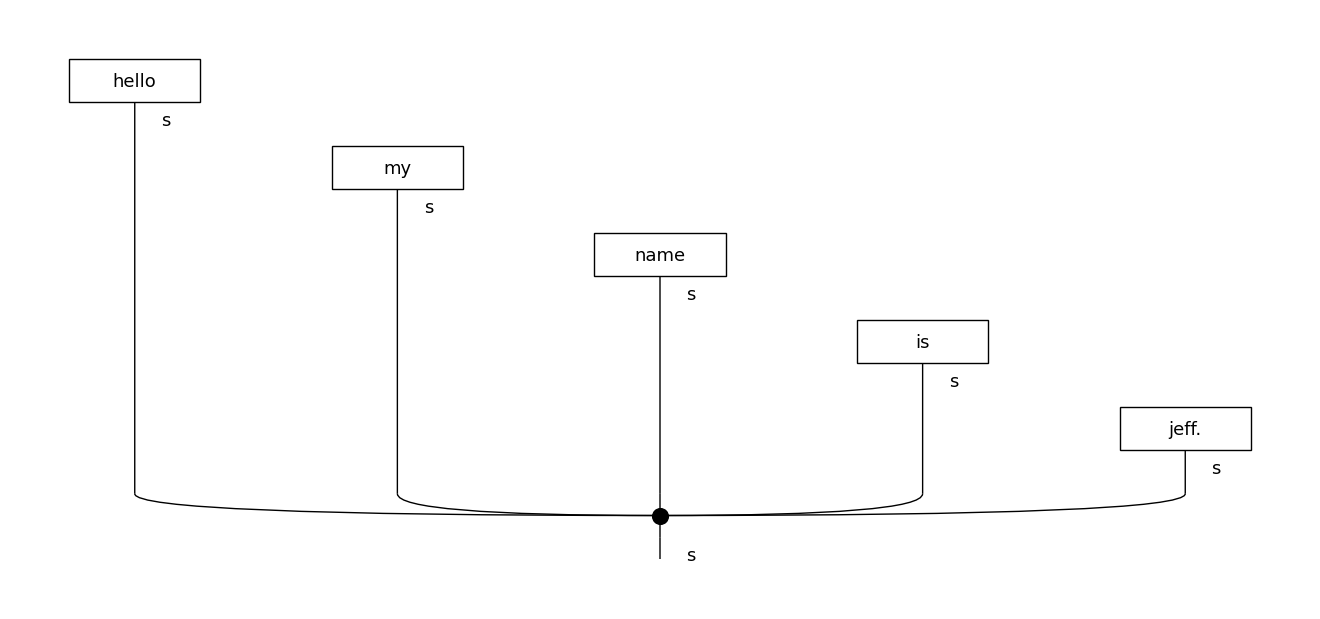

In [6]:
from lambeq import spiders_reader
spiders_diagram = spiders_reader.sentence2diagram(sample_sentence)
spiders_diagram.draw(figsize = (13, 6), fontsize = 13)

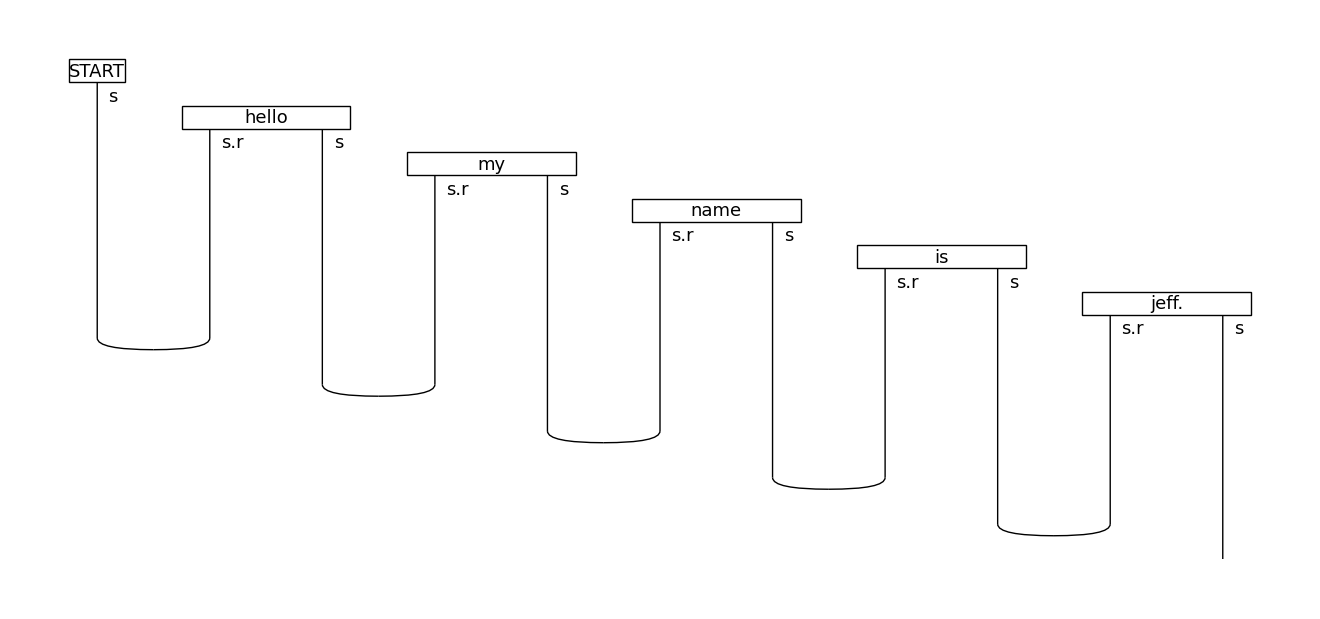

In [7]:
from lambeq import cups_reader
cups_diagram = cups_reader.sentence2diagram(sample_sentence)
cups_diagram.draw(figsize = (13, 6), fontsize = 13)

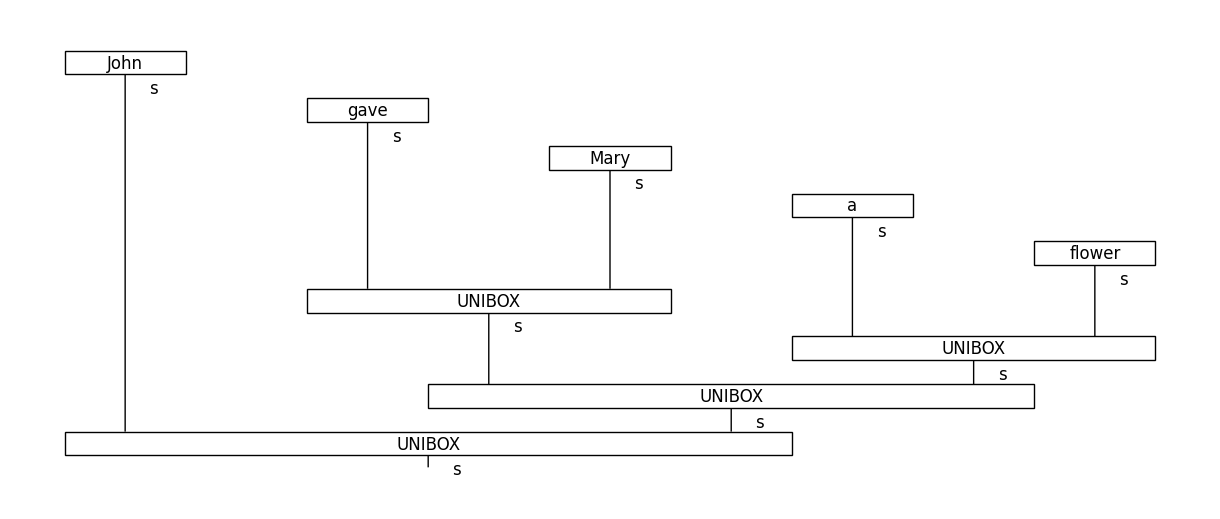

In [8]:
from lambeq import TreeReader

reader = TreeReader()
sentence = "John gave Mary a flower"

tree_diagram = reader.sentence2diagram(sentence)
tree_diagram.draw(figsize=(12,5), fontsize=12)

In [9]:
# Sentence diagram to quantum circuit conversion

# Start with a sample sentence w/ the Bobcat Parser

from lambeq import BobcatParser

sentence = 'John walks in the park'

# Get a string diagram
parser = BobcatParser(verbose='text')
diagram = parser.sentence2diagram(sentence)



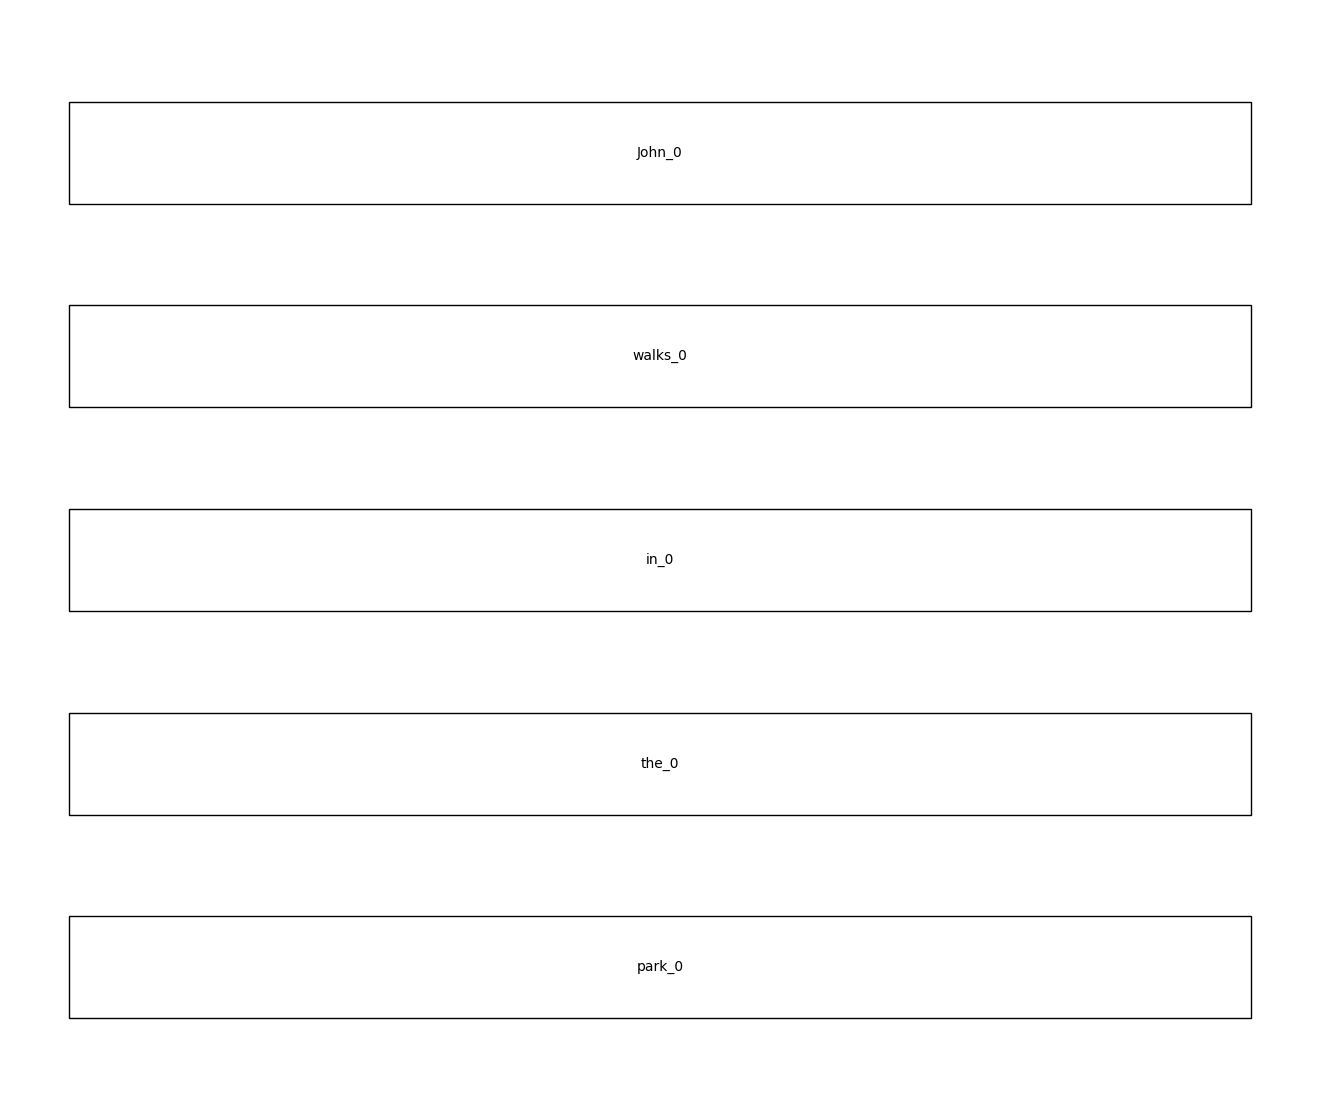

In [15]:
from lambeq import AtomicType, IQPAnsatz, MPSAnsatz

# IQP -- Instantaneous Quantum Polynomial
# MPS -- Matrix Product State

N = AtomicType.NOUN
S = AtomicType.SENTENCE
ansatz = IQPAnsatz({N: 1, S: 1}, n_layers = 2)
ansatz_2 = MPSAnsatz({N: 1, S: 1}, bond_dim = 2, max_order = 5)

discopy_circuit = ansatz(diagram)
#discopy_circuit_2 = ansatz_2(diagram)
discopy_circuit.draw(figsize = (13, 11))

In [12]:
ansatz

In [16]:
from pytket.circuit.display import render_circuit_jupyter

tket_circuit = discopy_circuit.to_tk()

render_circuit_jupyter(tket_circuit)

In [17]:
# Training -- classical

import torch

BATCH_SIZE = 30
EPOCHS = 30
LEARNING_RATE = 3e-2
SEED = 0


def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../examples/datasets/mc_train_data.txt')
val_labels, val_data = read_data('../examples/datasets/mc_dev_data.txt')
test_labels, test_data = read_data('../examples/datasets/mc_test_data.txt')


FileNotFoundError: ignored

In [ ]:
# Data preparation -- convert all the sentences to sentence diagrams

from lambeq import BobcatParser

parser = BobcatParser(verbose='text')

train_diagrams = parser.sentences2diagrams(train_data)
val_diagrams = parser.sentences2diagrams(val_data)
test_diagrams = parser.sentences2diagrams(test_data)


# For now, just use a simple bag of words model -- spider ansatz

from discopy.tensor import Dim

from lambeq import AtomicType, SpiderAnsatz

ansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),
                       AtomicType.SENTENCE: Dim(2)})

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
val_circuits =  [ansatz(diagram) for diagram in val_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw()




In [ ]:
# Pytorch model

from lambeq import PytorchModel, PytorchTrainer

all_circuits = train_circuits + val_circuits + test_circuits
model = PytorchModel.from_diagrams(all_circuits)

sig = torch.sigmoid

def accuracy(y_hat, y):
    return torch.sum(torch.eq(torch.round(sig(y_hat)), y))/len(y)/2  # half due to double-counting

eval_metrics = {"acc": accuracy}

trainer = PytorchTrainer(
        model=model,
        loss_function=torch.nn.BCEWithLogitsLoss(),
        optimizer=torch.optim.AdamW,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        verbose='text',
        seed=SEED)

from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

trainer.fit(train_dataset, val_dataset, eval_interval=1, log_interval=5)



In [ ]:
# Results visualization

import matplotlib.pyplot as plt
import numpy as np

fig1, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharey='row', figsize=(10, 6))

ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Epochs')
ax_br.set_xlabel('Epochs')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
test_acc = accuracy(model(test_circuits), torch.tensor(test_labels))
print('Test accuracy:', test_acc.item())


In [18]:
# Custom wrappers on Pytorch model??

class MyCustomModel(PytorchModel):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Linear(2, 2)

    def forward(self, input):
        """define a custom forward pass here"""
        preds = self.get_diagram_output(input)
        preds = self.net(preds.float())
        return preds

NameError: ignored